# ebtel++ Tests: Strong Impulsive Heating and TR/Coronal DEMs

In [52]:
import os
import sys
import copy
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

sys.path.append('/home/wtb2/Documents/codes/rsp_toolkit/python/')
from xml_io import OutputHandler,InputHandler

%matplotlib inline

## Heating Parameter Space

The heating parameters 

| Heating | Flare Duration [s] | Delay [s]  |
|:-------:|:--------------:|:-------:|
|25.0000  |    13.0000     | 4071.00 |
|25.0000  |    20.0000     | 4071.00 |
|25.0000  |    32.0000     | 4071.00 |
|10.6670  |    5.00000     | 5493.00 |
|25.0000  |    5.00000     | 5493.00 |
|10.6670  |    8.00000     | 5493.00 |
|25.0000  |    8.00000     | 5493.00 |
|25.0000  |    13.0000     | 5493.00 |
|10.6670  |    5.00000     | 7411.00 |
|25.0000  |    5.00000     | 7411.00 |
|25.0000  |    8.00000     | 7411.00 |
|25.0000  |    5.00000     | 10000.0 |
|25.0000  |    8.00000     | 10000.0 |

In [79]:
event_parameters = [
      {'magnitude':25.0000,      'duration':13.0000,      'delay':4071.00},
      {'magnitude':25.0000,      'duration':20.0000,      'delay':4071.00},
      {'magnitude':25.0000,      'duration':32.0000,      'delay':4071.00},
      {'magnitude':10.6670,      'duration':5.00000,      'delay':5493.00},
      {'magnitude':25.0000,      'duration':5.00000,      'delay':5493.00},
      {'magnitude':10.6670,      'duration':8.00000,      'delay':5493.00},
      {'magnitude':25.0000,      'duration':8.00000,      'delay':5493.00},
      {'magnitude':25.0000,      'duration':13.0000,      'delay':5493.00},
      {'magnitude':10.6670,      'duration':5.00000,      'delay':7411.00},
      {'magnitude':25.0000,      'duration':5.00000,      'delay':7411.00},
      {'magnitude':25.0000,      'duration':8.00000,      'delay':7411.00},
      {'magnitude':25.0000,      'duration':5.00000,      'delay':10000.0},
      {'magnitude':25.0000,      'duration':8.00000,      'delay':10000.0},
]

In [80]:
hxr_results = []

## Base Configuration
Use supplied heating configuration file as a base, change a few of the parameters.

In [81]:
ih = InputHandler('hxr_heating_tests_ebtel.xml')
base_config = ih.lookup_vars()
# make any modificiations to the base configuration here
base_config['heating']['partition'] = 0.5
base_config['use_adaptive_solver'] = True
base_config['total_time'] = 2e4
base_config['output_filename'] = 'hxr_heating_tests'

## Configure Each Run, Run Simulation

In [82]:
for params in event_parameters:
    print('Running simulation for H={}, tau={}, tN={}'.format(params['magnitude'],params['duration'],params['delay']))
    # configure heating
    num_events = int(np.round(base_config['total_time']/(params['duration'] + params['delay'])))
    event_list = []
    for i in range(num_events):
        rs = i*(params['duration'] + params['delay'])
        event_list.append({'event':{
            'decay_start':rs + params['duration']/2.,
            'decay_end':rs + params['duration'],
            'rise_start':rs,
            'rise_end':rs + params['duration']/2.,
            'magnitude':params['magnitude']
        }
        })
    # print configuration
    oh = OutputHandler('hxr_tmp_config.xml',copy.deepcopy(base_config))
    oh.output_dict['heating']['events'] = event_list
    oh.print_to_xml()
    # run simulation
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c','hxr_tmp_config.xml'])
    # read results
    tmp_res = np.loadtxt('hxr_heating_tests')
    tmp_dem_corona = np.loadtxt('hxr_heating_tests.dem_corona')
    hxr_results.append(
        {'results':tmp_res,
         'dem_temperature':tmp_dem_corona[0,:],
         'dem_tr':np.loadtxt('hxr_heating_tests.dem_tr')[1:,:],#np.average(np.loadtxt('hxr_heating_tests.dem_tr')[1:,:],weights=np.gradient(tmp_res[:,0]),axis=0),
         'dem_corona':tmp_dem_corona[1:,:]#np.average(tmp_dem_corona[1:,:],weights=np.gradient(tmp_res[:,0]),axis=0)
        }
    )

Running simulation for H=25.0, tau=13.0, tN=4071.0
Running simulation for H=25.0, tau=20.0, tN=4071.0
Running simulation for H=25.0, tau=32.0, tN=4071.0
Running simulation for H=10.667, tau=5.0, tN=5493.0
Running simulation for H=25.0, tau=5.0, tN=5493.0
Running simulation for H=10.667, tau=8.0, tN=5493.0
Running simulation for H=25.0, tau=8.0, tN=5493.0
Running simulation for H=25.0, tau=13.0, tN=5493.0
Running simulation for H=10.667, tau=5.0, tN=7411.0
Running simulation for H=25.0, tau=5.0, tN=7411.0
Running simulation for H=25.0, tau=8.0, tN=7411.0
Running simulation for H=25.0, tau=5.0, tN=10000.0
Running simulation for H=25.0, tau=8.0, tN=10000.0


## Plot Results

In [83]:
colors = sns.color_palette('Set1',n_colors=len(event_parameters))

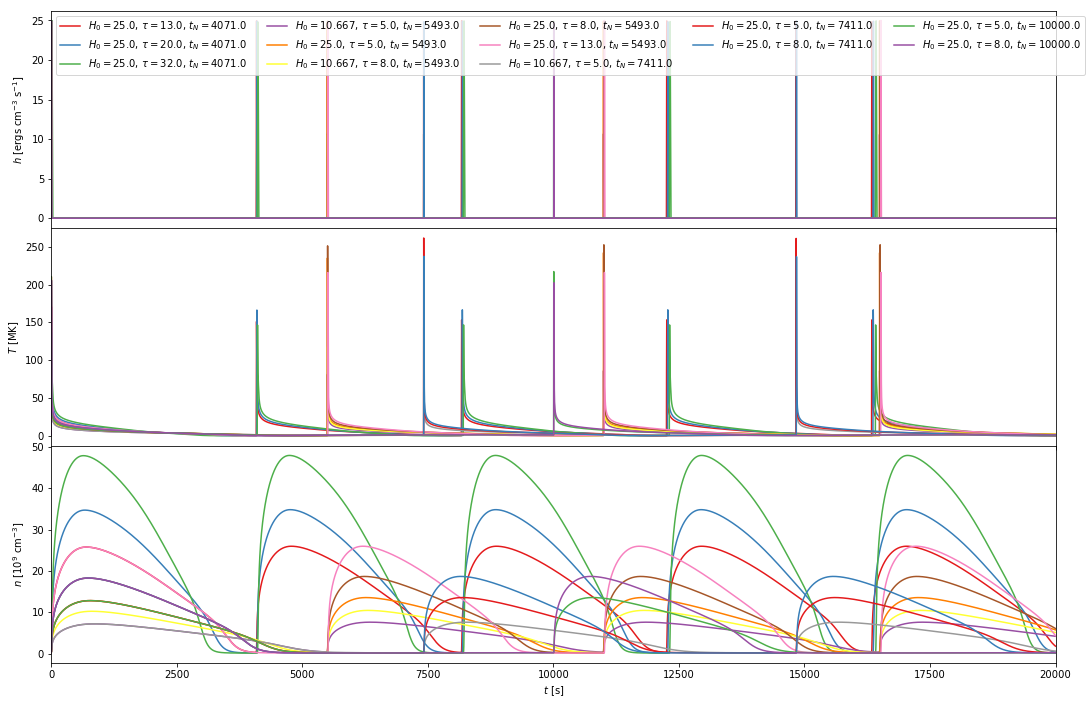

In [95]:
fig,axes = plt.subplots(3,1,figsize=(18,12),sharex=True)
plt.subplots_adjust(hspace=0)
for res,params,col in zip(hxr_results[:],
                          event_parameters[:],
                          colors[:]):
    label = r'$H_0={},\,\tau={},\,t_N={}$'.format(params['magnitude'],params['duration'],params['delay'])
    axes[0].plot(res['results'][:,0],res['results'][:,-1],label=label,color=col)
    axes[1].plot(res['results'][:,0],res['results'][:,1]/1e6,color=col)
    #axes[1].plot(res['results'][:,0],res['results'][:,2]/1e6,color=col,ls='--')
    axes[2].plot(res['results'][:,0],res['results'][:,3]/1e9,color=col)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].legend(loc=0,ncol=5)
axes[2].set_xlabel(r'$t$ [s]')
axes[0].set_ylabel(r'$h$ [ergs cm$^{-3}$ s$^{-1}$]')
axes[1].set_ylabel(r'$T$ [MK]')
axes[2].set_ylabel(r'$n$ [$10^9$ cm$^{-3}$]')

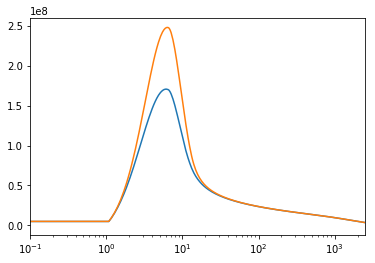

In [101]:
test_res = hxr_results[0]['results']
plt.plot(test_res[:,0],test_res[:,1])
plt.plot(test_res[:,0],test_res[:,2])
plt.xlim([0.1,2500])
plt.xscale('log')

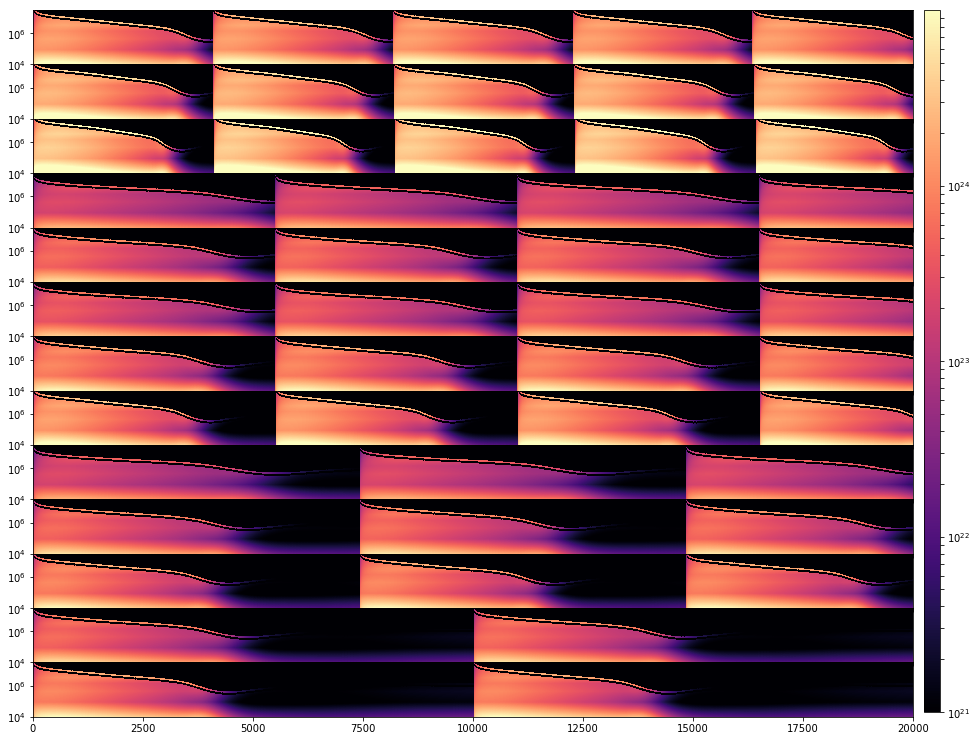

In [90]:
fig,axes = plt.subplots(len(hxr_results),1,figsize=(15,1.*len(hxr_results)),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,right=0.94)
cax = fig.add_axes([0.95,0.13,0.015,0.75])
for res,ax in zip(hxr_results,axes.flatten()):
    temp_mesh,time_mesh = np.meshgrid(res['dem_temperature'],
                                      res['results'][:,0],)
    im = ax.pcolormesh(time_mesh,temp_mesh,
                   res['dem_tr'] + res['dem_corona'],
                   norm=matplotlib.colors.SymLogNorm(10,vmin=1e21,vmax=1e25),
                      cmap=plt.get_cmap('magma'))
# labels, limits, scale
axes[0].set_yscale('log')
axes[0].set_ylim([1e4,10**(7.5)])
axes[0].set_xlim([0,base_config['total_time']])
fig.colorbar(im,cax=cax)

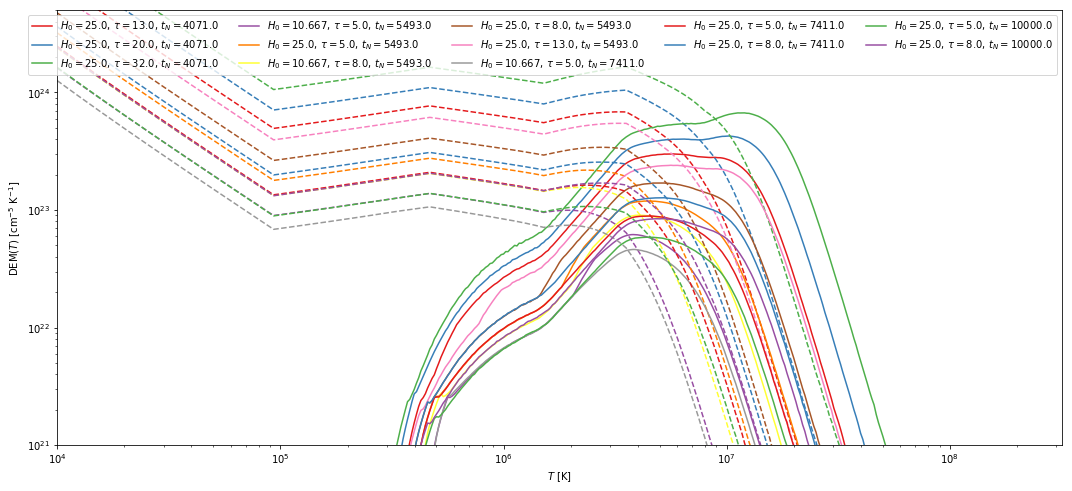

In [93]:
fig = plt.figure(figsize=(18,8))
ax = fig.gca()
for res,params,col in zip(hxr_results[:],
                          event_parameters[:],
                          colors[:]):
    label = r'$H_0={},\,\tau={},\,t_N={}$'.format(params['magnitude'],params['duration'],params['delay'])
    ax.plot(res['dem_temperature'],
            np.average(res['dem_tr'],weights=np.gradient(res['results'][:,0]),axis=0),
            ls='--',color=col)
    ax.plot(res['dem_temperature'],np.average(res['dem_corona'],weights=np.gradient(res['results'][:,0]),axis=0),
            ls='-',label=label,color=col)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10.**(4),10.**(8.5)])
ax.set_ylim([1e21,5e24])
ax.legend(loc=1,ncol=5)
ax.set_ylabel(r'$\mathrm{DEM}(T)$ [cm$^{-5}$ K$^{-1}$]')
ax.set_xlabel(r'$T$ [K]')